In [1]:
#!pip install pandas
#!pip install seaborn

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf

import matplotlib.pyplot as plt
import random
import os
#print(os.listdir("../input/dogs-vs-cats/"))

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Preprocessing Data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [6]:
basepath = "D:/Datasets/dogs-vs-cats/"
filenames = os.listdir(basepath+"train/")

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

files_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
files_df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [8]:
train_df, validate_df = train_test_split(files_df, 
                                         test_size=0.20,                                         
                                         random_state=0)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [9]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Preparing Image Data

In [10]:
train_path = basepath+"train/"
test_path = basepath+"test1/"

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validate_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Creating CNN Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D

In [14]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
def create_model():        
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu',
                     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(60, (3, 3), activation='relu',strides=2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])

    #model.summary()
    return model

In [17]:
def createVGG16model():
    pretrained_model = VGG16(weights='imagenet', include_top=False ,input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    pretrained_model.trainable = False 
    
    model = Sequential([pretrained_model,
                        GlobalAveragePooling2D(),
                        Dense(2, activation='softmax')])

    model.compile(optimizer='adam',
                    loss = 'categorical_crossentropy',
                    metrics=['accuracy'])

    return model

### Callbacks

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fitting the Model

In [19]:
%%time
if FAST_RUN :
    epochs = 3
else:
    epochs = 50

#with strategy.scope():
with tf.device("/gpu:0"):   
    #model = createVGG16model()
    model = create_model()
    history = model.fit(train_generator, 
                        epochs=epochs,
                        validation_data=validation_generator,
                        validation_steps=1,
                        steps_per_epoch=total_train//batch_size,
                        callbacks=callbacks)

model.save_weights("./Models/model.h5")

Epoch 1/50
1333/1333 [==============================] - 400s 300ms/step - loss: 0.6773 - accuracy: 0.6040 - val_loss: 0.7114 - val_accuracy: 0.7333
Epoch 2/50
1333/1333 [==============================] - 124s 93ms/step - loss: 0.6003 - accuracy: 0.6785 - val_loss: 0.6239 - val_accuracy: 0.6667
Epoch 3/50
1333/1333 [==============================] - 74s 56ms/step - loss: 0.5750 - accuracy: 0.6965 - val_loss: 0.4646 - val_accuracy: 0.8000
Epoch 4/50
1333/1333 [==============================] - 74s 56ms/step - loss: 0.5439 - accuracy: 0.7210 - val_loss: 0.6627 - val_accuracy: 0.6000
Epoch 5/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7414
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 73s 55ms/step - loss: 0.5239 - accuracy: 0.7414 - val_loss: 0.3696 - val_accuracy: 0.8000
Epoch 6/50
1333/1333 [==============================] - 73s 55ms/step - loss: 0.4937 - accuracy: 0.7

## Output Graph

<AxesSubplot:>

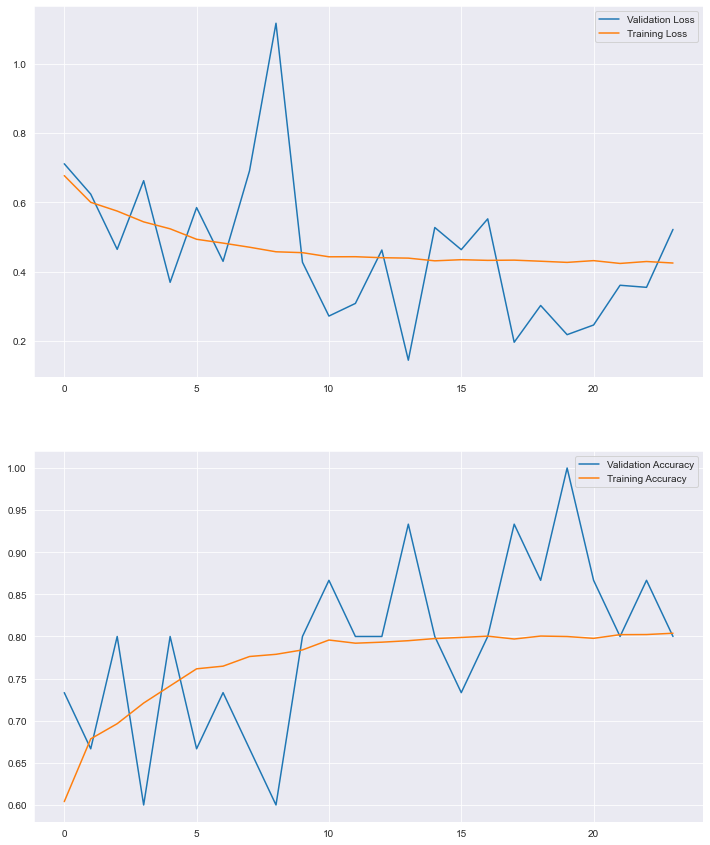

In [22]:
import seaborn as sns
his_dict = history.history
fig = plt.figure(figsize=(12, 15))
x_range = range(len(history.history['loss']))
sns.set_style('darkgrid')

fig.add_subplot(2,1,1)
sns.lineplot(x=x_range , y=his_dict["val_loss"],label='Validation Loss')
sns.lineplot(x=x_range , y=his_dict["loss"],label='Training Loss')

fig.add_subplot(2,1,2)
sns.lineplot(x=x_range , y=his_dict["val_accuracy"],label='Validation Accuracy')
sns.lineplot(x=x_range , y=his_dict["accuracy"],label='Training Accuracy')

In [34]:
print("Validation Accuracy {}".format(np.mean(his_dict['val_accuracy'])*100))
print("Validation Loss {}".format(np.mean(his_dict['val_loss'])*100))
print("Training Accuracy {}".format(np.mean(his_dict['accuracy'])*100))
print("Training Loss {}".format(np.mean(his_dict['loss'])*100))

Validation Accuracy 78.88889014720917
Validation Loss 45.90669218450785
Training Accuracy 77.01317692796388
Training Loss 47.2798412044843


## Predictions

In [36]:
test_filenames = os.listdir(basepath+"test1/") 
test_df = pd.DataFrame({
    'filename': test_filenames
})
idlist=[]
for file in test_df["filename"]:
    idlist.append(file.split(".")[0])

#test_df['ids'] = alist
nb_samples = test_df.shape[0]

In [37]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    basepath+"test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [38]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [39]:
test_df['category'] = np.argmax(predict, axis=-1)

In [40]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [41]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## Submission

In [42]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)